In [38]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np

from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils

import string

# logging for gensim (set to INFO)
import logging
import re
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import scipy.sparse
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn")
%matplotlib inline

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


### Import Clean Data from pickle file

In [2]:
df = pd.read_pickle('project4.pkl')

In [3]:
df

,script
Captain_Marvel_(2019),wan i new t vulnerable supreme dangerous warri...
Captain_America:_The_First_Avenger,many other russian come i long i t open long g...
Ant-Man,t happy poor revolutionary u good i such god e...
Iron_Man,crazy hey forrest sir s personal good i i i i ...
Iron_Man_2,i i u bodyguard mysterious undisclosed high of...
Spider-Man:_Homecoming,same mean alien big green indian s native amer...
Iron_Man_3,own doesn famous uh sigh let tony great i piti...
Thor:_The_Dark_World,such evil possible ancient infinite noble migh...
Captain_America:_The_Winter_Soldier,left uh left left new late whole good soft i m...
Avengers:_Age_of_Ultron,central other hydra loki s last long last litt...


#### Put Captain Marvel in a seperate dataframe

In [4]:
df20 = df.iloc[[0]]

In [7]:
df20 = pd.DataFrame(df20)

In [8]:
df20

,script
Captain_Marvel_(2019),wan i new t vulnerable supreme dangerous warri...


In [9]:
data = df.copy()

In [10]:
data.drop('Captain_Marvel_(2019)', axis=0, inplace=True)

In [11]:
data

,script
Captain_America:_The_First_Avenger,many other russian come i long i t open long g...
Ant-Man,t happy poor revolutionary u good i such god e...
Iron_Man,crazy hey forrest sir s personal good i i i i ...
Iron_Man_2,i i u bodyguard mysterious undisclosed high of...
Spider-Man:_Homecoming,same mean alien big green indian s native amer...
Iron_Man_3,own doesn famous uh sigh let tony great i piti...
Thor:_The_Dark_World,such evil possible ancient infinite noble migh...
Captain_America:_The_Winter_Soldier,left uh left left new late whole good soft i m...
Avengers:_Age_of_Ultron,central other hydra loki s last long last litt...
Captain_America:_Civil_War,standard small quiet good mean cross compromis...


In [18]:
m4= ['Captain_America:_The_First_Avenger', 'Ant-Man',
              'Iron_Man', 'Iron_Man_2', 'Spider-Man:_Homecoming', 'Iron_Man_3', 
             'Thor:_The_Dark_World', 'Captain_America:_The_Winter_Soldier', 'Avengers:_Age_of_Ultron',
              'Captain_America:_Civil_War', 'Avengers:_Infinity_War', 'Avengers:_Endgame', 'Doctor Strange', 'Avengers', 'Black Panther']

In [31]:
m5= ['Captain_Marvel_(2019)','Captain_America:_The_First_Avenger', 'Ant-Man',
              'Iron_Man', 'Iron_Man_2', 'Spider-Man:_Homecoming', 'Iron_Man_3', 
             'Thor:_The_Dark_World', 'Captain_America:_The_Winter_Soldier', 'Avengers:_Age_of_Ultron',
              'Captain_America:_Civil_War', 'Avengers:_Infinity_War', 'Avengers:_Endgame', 'Doctor Strange', 'Avengers', 'Black Panther']


In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['iron','sigh','hope','english','scott','stark', 'pym', 'vers', 'peter', 'stephen', 'skrulls', 
                   'simmed', "alright", 'nebula', 'subtitled', 'meant', 'natasha', 'ultron', 'bucky', 'asgard', 'pull', 'tried',
                   'obsidian', 'glaive', 'clint', 'cont', 'heimdall', 'ivan', 'librarian', 
                   'gamora', 'rhodey', 'heidmall', 'coulson', 'pierce', 'rumlow', 'peggy', 'sitwell', 'nat', 'hulk', 'banner', 'barton',
                     'quill', 'groot','na', 'tony', 'dormammu', 'rogers', 'carter', 'steve', 'dr', 'agent','mr', 'strange', 
                      'bruce', 'uhh', 'howard','uh','ve', 'skrull', 're', 'ned', 'liz', 'kree', 'yeah', 'soh', 'lawson', 'whoa',
                        'ok', 'wanda', 'wong', 'joseph','schmidt', 'ant', 'gale', 'cassie', 'isn', 'padton', 'lang', 'zola', 'shield', 
                        'erskine', 'morita', 'didn', 'spider', 'okay', 'miss', 'daddy', 'seventh', 'happy', 'sub', 'sayin',
                        'manhattan','parker', "kaecilius", "hank", "captain", "taj", "america", "carol", "fury",
                        'green',"pepper", "jarvis", "larr", "mar", "kamar", "mordo", 'obadiah', "hydra", "dave", 
                        'russian', 'french','luis', 'kurt', 'scotty', 'karen', "paxton", "yinsen", 'goose', 'asguar' 
                        'portal', 'port' 'voiceover','sir', 'doin', 'olive', 'nakia', 'okoye', 'ext', 'killmonger', 'klaue',
                        'london','nick', 'guardian', 'yup', 'thanos', 'gamma', 'dude', 'erik', "asgardian",
                               'wakandan', 'um', 'ext', 'thor', 'loki', 'fandral', 'selvig', 'darcy', 'shuri',
                                  'int', 'southkorea', 'odin', 'jane', 'sif', 'ross', 'volstagg', 
                                   "supreme","flerken", "ronan", "sam", "untranslated", "ramonda", 
                                   'blue','black','lexus', "zuri", "shur", 'copy', 'korean', 'hogan', 'laufey', 'frigga', 'african'])

### TFIDF + NMF for topic modeling

In [13]:
tfidf1 = TfidfVectorizer(stop_words=stop_words, min_df = .1, max_df = .7)
movie_df = tfidf1.fit_transform(data.script)

In [14]:
nmf_model = NMF(6, random_state=45)
doc_topic = nmf_model.fit_transform(movie_df)

In [15]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [16]:
display_topics(nmf_model, tfidf1.get_feature_names(), 10)


Topic  0
web, huge, cool, normal, large, awesome, alien, wide, left, enhanced

Topic  1
helicarrier, mercenary, portal, electric, civilian, secret, nuclear, chitauri, angry, flash

Topic  2
fantastic, ten, complete, fair, unbelievable, major, arc, dry, military, effective

Topic  3
dark, ancient, library, ritual, ship, eternal, mystic, universe, dimensional, astral

Topic  4
spear, sonic, warrior, massive, kinetic, large, tough, several, third, wooden

Topic  5
enlistment, nazi, sergeant, tower, super, crowd, late, stronger, beautiful, loud


In [19]:
movie_topic = pd.DataFrame(doc_topic.round(3), index=m4)
movie_topic

,0,1,2,3,4,5
Captain_America:_The_First_Avenger,0.000,0.000,0.000,0.000,0.000,1.036
Ant-Man,0.269,0.000,0.134,0.000,0.000,0.160
Iron_Man,0.000,0.000,0.795,0.000,0.000,0.000
Iron_Man_2,0.000,0.000,0.783,0.000,0.005,0.000
Spider-Man:_Homecoming,0.507,0.000,0.000,0.000,0.000,0.000
Iron_Man_3,0.311,0.000,0.136,0.000,0.000,0.014
Thor:_The_Dark_World,0.000,0.000,0.029,0.721,0.000,0.018
Captain_America:_The_Winter_Soldier,0.000,0.773,0.000,0.000,0.000,0.020
Avengers:_Age_of_Ultron,0.001,0.507,0.232,0.043,0.000,0.011
Captain_America:_Civil_War,0.467,0.018,0.000,0.000,0.000,0.000


### PCA transformation and PCA Visualization

In [20]:
pca = PCA(n_components=2)
pca.fit(movie_topic)
pcafeatures = pca.transform(movie_topic)

In [21]:
pcafeatures

array([[-0.13395954,  0.10586598],
       [-0.05814606,  0.13504694],
       [ 0.09982306,  0.59627049],
       [ 0.09728331,  0.58758749],
       [-0.09485523,  0.03188897],
       [-0.04837531,  0.12475287],
       [-0.42857036, -0.3110638 ],
       [ 0.57755089, -0.34811549],
       [ 0.38249692, -0.07446559],
       [-0.07537677,  0.02170708],
       [-0.0770209 , -0.00650901],
       [-0.17310598, -0.16960402],
       [-0.49582941, -0.38887596],
       [ 0.58040031, -0.35045529],
       [-0.15231494,  0.04596933]])

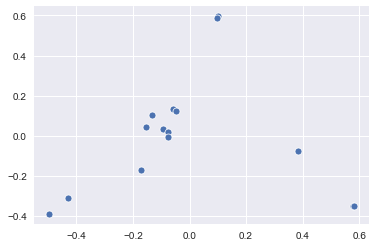

In [22]:
sns.scatterplot(pcafeatures[:,0], pcafeatures[:,1])

In [24]:
df5 = tfidf1.transform(df20.script)
df6 = nmf_model.transform(df5)
pcafeatures2 = pca.transform(df6)

In [25]:
df6

array([[0.15122852, 0.04578466, 0.10739722, 0.02969754, 0.08272817,
        0.03395791]])

In [26]:
pcafeatures2

array([[-0.02468814,  0.06588611]])

In [27]:
pcalist = np.concatenate((pcafeatures2, pcafeatures))

In [28]:
pcalist

array([[-0.02468814,  0.06588611],
       [-0.13395954,  0.10586598],
       [-0.05814606,  0.13504694],
       [ 0.09982306,  0.59627049],
       [ 0.09728331,  0.58758749],
       [-0.09485523,  0.03188897],
       [-0.04837531,  0.12475287],
       [-0.42857036, -0.3110638 ],
       [ 0.57755089, -0.34811549],
       [ 0.38249692, -0.07446559],
       [-0.07537677,  0.02170708],
       [-0.0770209 , -0.00650901],
       [-0.17310598, -0.16960402],
       [-0.49582941, -0.38887596],
       [ 0.58040031, -0.35045529],
       [-0.15231494,  0.04596933]])

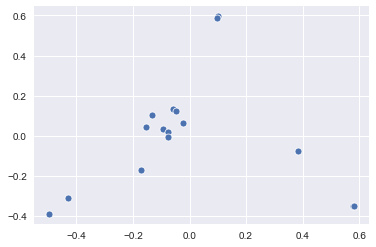

In [29]:
sns.scatterplot(pcalist[:,0], pcalist[:,1])

In [32]:
df11 = pd.DataFrame(pcalist, index=m5, columns=['pca1', 'pca2'])

In [34]:
df11.to_csv('pca31.csv')

In [36]:
pca.components_

array([[-0.13381527,  0.78476898,  0.15953955, -0.56078771, -0.12505395,
        -0.1032323 ],
       [ 0.04573554, -0.46402629,  0.73908106, -0.47557059,  0.03719389,
         0.09378854]])

In [37]:
df11

,pca1,pca2
Captain_Marvel_(2019),-0.024688,0.065886
Captain_America:_The_First_Avenger,-0.133960,0.105866
Ant-Man,-0.058146,0.135047
Iron_Man,0.099823,0.596270
Iron_Man_2,0.097283,0.587587
Spider-Man:_Homecoming,-0.094855,0.031889
Iron_Man_3,-0.048375,0.124753
Thor:_The_Dark_World,-0.428570,-0.311064
Captain_America:_The_Winter_Soldier,0.577551,-0.348115
Avengers:_Age_of_Ultron,0.382497,-0.074466
